# P5 Computational Vision

**Important:** Read the file `README.md` before start coding.

<div class = "alert alert-info" style = "border-radius:10px;border-width:3px;border-color:darkblue;font-family:Verdana,sans-serif;font-size:16px;">
    
**Delivery**
<ol>

Requirements to fulfill:
<ul>
    <li>  Answer the questions introduced in the exercises.
    <li>  The implemented code should be,<br>
        - free of errors (Run All before delivery and check for possible errors)<br>
        - optimized ( e.g. do not use 'for' instruction when indexing numpy arrays)<br>
        - readable  ( e.g. avoiding the implementation of more than 2 loops within a line)<br>
        - commented and with descriptions      
    <li> The deliverable must be a file named **P4_Student1_Student2.zip** that includes:
    <ul>
        <li> The notebook P4_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
         <li> All the images used in this notebook.
    </ul>

</ul>

 **Deadline (Campus Virtual): November 11th, 23:00 h** 


</ol>
</div>

## Face detection

The main topics of this notebook:

- Integral images and a classical use for fast haar-like feature computation.
- Viola & Jones face detection method applied in a video.



In [35]:
import numpy as np
from skimage import io
import os
from glob import glob
import matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt

%matplotlib inline

**Exercise 1:**

1) Build a function `compute_integral_image` that computes the integral image of an input (2D) array.


In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```python
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .

```
The integral image must have an additional row and column full of zeros (first row and first column).

```python
 def compute_integral_image(img_arr):
    row_sum = np.zeros(img_arr.shape)
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    # Add code here
    
    return integral_image_arr
```


2) Make sure that the values of the integral image are correct.


3) Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```


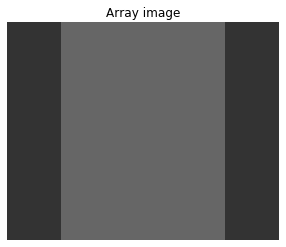

In [3]:
img_array = np.array([
    [1, 2, 2, 2, 1],
    [1, 2, 2, 2, 1],
    [1, 2, 2, 2, 1],
    [1, 2, 2, 2, 1]
])

plt.imshow(img_array, cmap='gray', vmin=0, vmax=5)
plt.title('Array image')
plt.axis('off')
plt.show()

In [10]:
def compute_integral_image(img_arr: np.ndarray) -> np.ndarray:
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :return Integral image of "img_arr"
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    
    # Add code here
    integral_image_arr[1:, 1:] = np.cumsum(np.cumsum(img_arr, axis=0), axis=1)

    return integral_image_arr

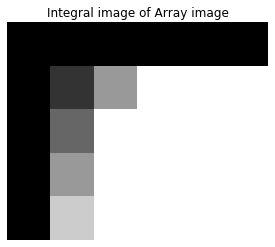

In [12]:
ii_img_array = compute_integral_image(img_array)

plt.imshow(ii_img_array, cmap='gray', vmin=0, vmax= 5)
plt.title('Integral image of Array image')
plt.axis('off')
plt.show()

**Exercise 2:**

1) Create a function `sum_region` to compute the  sum of the pixel intensities within a  rectangle using the integral image. 

The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

Make the function with the following header:
```
def sum_region(integral_img_arr, top_left, bottom_right):
```

2) You can make the following tests:
 
 - `sum(img_array) == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`
 

In [17]:
assert(img_array.sum() == ii_img_array[-1, -1])
assert(img_array[0, :].sum() == ii_img_array[1, -1])

In [18]:
def sum_region(integral_img_arr, tl, br):
    tr = (tl[0], br[1])
    bl = (br[0], tl[1])
    
    return integral_img_arr[tl] + integral_img_arr[br] - (integral_img_arr[tr] + integral_img_arr[bl])

In [19]:
# result you should get (12)
sum_region(ii_img_array, tl=(1, 1), br=(3, 4))

12.0

In [20]:
# result you should get (32)
sum_region(ii_img_array, tl=(0, 0), br=(-1, -1))

32.0

**Exercise 3:**

Compute the integral image for a set of images.
    
To do so build a function `load_integral_images` to read all the images inside a given folder and compute the integral image of every image:

```python
def load_integral_images(path):
    images = []
    for _file in os.listdir(path):
       #### Complte here:
       #### Read image
       #### Remember to scale the image (with the max pixel intensity value)
     
    return ii_images
 ```

In [21]:
pos_training_path = 'trainingdata/faces'
neg_training_path = 'trainingdata/nonfaces'
pos_testing_path =  'trainingdata/faces/test'
neg_testing_path =  'trainingdata/nonfaces/test'

In [39]:
def load_integral_images(path):
    """Read each file in the folder, calculate its integral image and normalize the image."""
    ii_images = []
    
    for file_path in glob(f'{path}/*.png'):
        img = io.imread(file_path)
        
        i_img = compute_integral_image(img)
        
        ii_images.append(i_img / i_img.max())
    
    return ii_images

In [41]:
integral_images = load_integral_images('trainingdata/faces')

**Exercise 4:** 

Compute the Haar features of an image

We provide you with `HaarLikeFeature` class that has build in a `get_score` function and a `get_vote` function.

Your job is to complete the code of the method `_create_features` in the class `HaarLikeFeature`:

```python
def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
                # Notice that Haarlike features contain polarity, append features for polarity 1 and -1
                # The threshold can be set to 0 for all of them.
                
                
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features
```

In [10]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)


In [11]:

def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    
    :return: List of selected features
    :rtype: list[HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1)) 

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=8)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))

    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')


    return classifiers

def _get_feature_vote(feature, image):
    return feature.get_vote(image)

def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                ########################
                ### FILL IN HERE
                ########################
                pass # remove this pass
            
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features

**Exercise 5:** Use the learn method  to learn a list of two classifiers with the train data

With the `learn` function you can build a list of classifiers that detect whether an image contains a face or not.

Use the following hyperparameters of the features and `num_classifiers`.

In [12]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [13]:
%%time 
#classifiers = learn(...)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


**Exercise 6:** Make a function for voting with different classifiers

Build two functions `ensemble_vote` and `ensemble_vote_all`.

- `ensemble_vote(int_img, classifiers)` has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise

- `ensemble_vote_all(int_imgs, classifiers)` has to loop over the list `int_imgs` and compute the `ensemble_vote` for each image in the list. It has to return a list containing all the votes for all the images in  `int_imgs`.

Use the functions to compute the train and test acurracies for faces and non faces.

Print the results in the following format:
```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [14]:
# Solution here
def ensemble_vote(int_img, classifiers):
    return

In [15]:
# Solution here
def ensemble_vote_all(int_imgs, classifiers):
    return



**Exercise 7:** Make another test with 20 classifiers instead of 2.

Inspect the classification results if you use adaboost with 20 classifiers. Use the same hyperameters for the features.
Print the results as in the previous exercise.

- Discuss if the classification results improved in the train data.



In [16]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [17]:
%%time 
#classifiers_20 = learn(...)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


**Exercise 8** Change the voting functions so that you can set a threshold for deciding a prediction.

The threshold value indicates the minimum score for assigning a "positive" label (detect a face).

Create the following functions

- `ensemble_vote_t`: returns the final decision of a list of classifiers for a given threshold.
- `ensemble_vote_all_t`: Iterates over a list of integral images and returns the  final decision of a list of classifiers for each of the images (for a given threshold).



Using the list of 20 classifiers compute the following:

- a) number of correct faces over all faces (in the train data)
- b) number of correct non faces over all non faces (in the train data)
- c) number of correct faces over all faces (in the test data)
- d) number of correct non faces over all non faces (in the test data)




The quantities have to be computed for each of the following thresholds:

```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

- Make a bar plot for a) b) c) and d). In the x axis write the threshold value. 

- Discuss what happens when you increase the threshold value.

In [18]:
thresholds = np.array([x for x in range(-5,5,1)])/10.

In [19]:
correct_faces_train_t = []
correct_non_faces_train_t = []
correct_faces_test_t = []
correct_non_faces_test_t = []

In [20]:
def ensemble_score(int_img, classifiers):
    return sum([c.get_vote(int_img) for c in classifiers])

def ensemble_vote_t(int_img, classifiers,t):
    return

def ensemble_vote_all_t(int_imgs, classifiers,t=-0.1):
    votes = []

    
    return votes

